In [71]:
# Block 1 – Import Library Utama
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib  # untuk export model


In [72]:
# Block 2 – Load Dataset
df = pd.read_csv("datasets/laptop_price.csv", encoding="latin1")
print("Shape:", df.shape)
df.head()


Shape: (1303, 13)


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [73]:
# Info dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [74]:
# Cek missing value
df.isna().sum()


laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

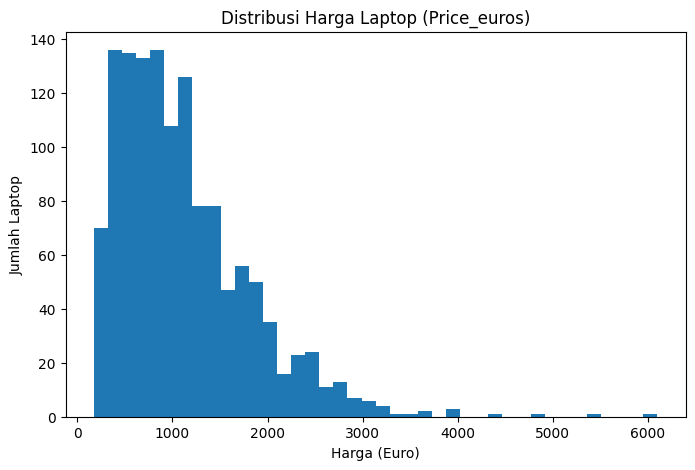

In [75]:
# Distribusi target (Price_euros)
plt.figure(figsize=(8, 5))
plt.hist(df["Price_euros"], bins=40)
plt.title("Distribusi Harga Laptop (Price_euros)")
plt.xlabel("Harga (Euro)")
plt.ylabel("Jumlah Laptop")
plt.show()


In [76]:
# Korelasi fitur numerik dengan Price_euros
num_cols = df.select_dtypes(exclude="object").columns
corr = df[num_cols].corr()

print("=== Korelasi Fitur Numerik terhadap Price_euros ===")
corr["Price_euros"].sort_values(ascending=False)


=== Korelasi Fitur Numerik terhadap Price_euros ===


Price_euros    1.000000
Inches         0.068197
laptop_ID      0.067830
Name: Price_euros, dtype: float64

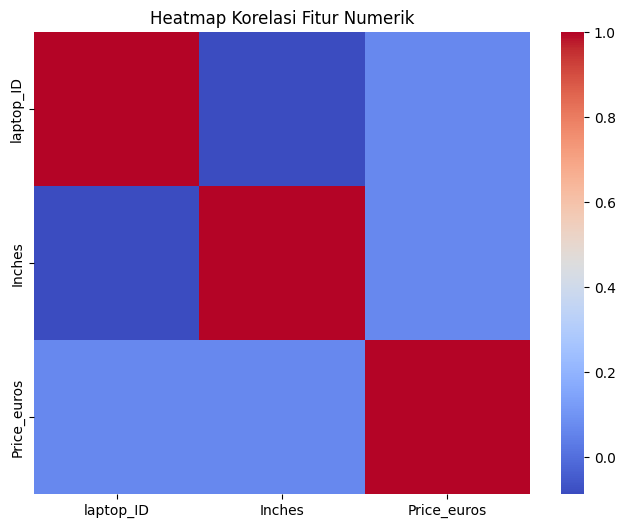

In [77]:
# Heatmap korelasi numerik
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()


In [78]:
# Block 3 – Pisahkan Fitur (X) dan Target (y)
X = df.drop("Price_euros", axis=1)
y = df["Price_euros"]

# Kolom kategorikal & numerik
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Fitur kategorikal :", categorical_features)
print("Fitur numerik     :", numerical_features)


Fitur kategorikal : ['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight']
Fitur numerik     : ['laptop_ID', 'Inches']


In [79]:
# Block 4 – ColumnTransformer untuk Encoding & Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features),
    ]
)

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training size:", X_train.shape)
print("Testing size :", X_test.shape)


Training size: (1042, 12)
Testing size : (261, 12)


In [80]:
# Block 5 – Fungsi Evaluasi (MAE, RMSE, R²)

def evaluate_regression_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"=== {model_name} ===")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.3f}")
    print("-" * 40)

    return {
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }


In [81]:
# Block 6 – Training Beberapa Model Dasar

results = []              # buat tabel perbandingan
fitted_models = {}        # simpan model yang sudah dilatih

# 6.1 – Linear, Ridge, Lasso
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=0.001, max_iter=10000)),
]

for name, estimator in models:
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", estimator),
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    res = evaluate_regression_model(y_test, y_pred, model_name=name)
    results.append(res)
    fitted_models[name] = pipe


=== Linear Regression ===
MAE  : 301.68
RMSE : 440.14
R²   : 0.619
----------------------------------------
=== Ridge Regression ===
MAE  : 160.62
RMSE : 248.86
R²   : 0.878
----------------------------------------
=== Lasso Regression ===
MAE  : 235.06
RMSE : 355.93
R²   : 0.751
----------------------------------------


C:\Users\Milan\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e+05, tolerance: 5.035e+04
  model = cd_fast.sparse_enet_coordinate_descent(


In [82]:
# 6.2 – Random Forest baseline (belum tuning)
rf_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )),
])

rf_baseline.fit(X_train, y_train)
y_pred_rf = rf_baseline.predict(X_test)

res_rf = evaluate_regression_model(y_test, y_pred_rf, model_name="Random Forest (Baseline)")
results.append(res_rf)
fitted_models["Random Forest (Baseline)"] = rf_baseline


=== Random Forest (Baseline) ===
MAE  : 189.44
RMSE : 359.26
R²   : 0.746
----------------------------------------


In [83]:
# Block 7 – Tabel Perbandingan Model
results_df = pd.DataFrame(results)
results_df


,Model,MAE,RMSE,R2
0,Linear Regression,301.676923,440.144169,0.618593
1,Ridge Regression,160.615195,248.862582,0.878068
2,Lasso Regression,235.059351,355.929333,0.750583
3,Random Forest (Baseline),189.444459,359.256677,0.745898


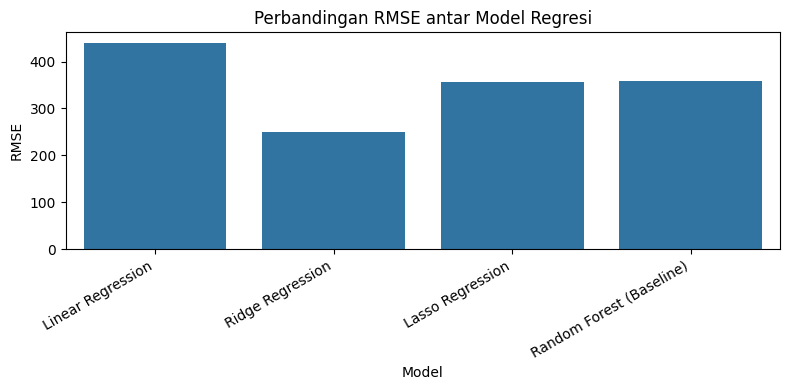

In [84]:
# Visualisasi perbandingan RMSE antar model
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="RMSE")
plt.xticks(rotation=30, ha="right")
plt.title("Perbandingan RMSE antar Model Regresi")
plt.tight_layout()
plt.show()


In [85]:
# Block 8 – Hyperparameter Tuning untuk Random Forest

# Pipeline khusus buat tuning
rf_for_search = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1)),
])

param_distributions = {
    "model__n_estimators": [100, 200, 300, 400],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    rf_for_search,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

rf_search.fit(X_train, y_train)

print("Best params:", rf_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 30}


In [86]:
# Evaluasi Random Forest hasil tuning
best_rf_pipeline = rf_search.best_estimator_

y_pred_rf_tuned = best_rf_pipeline.predict(X_test)

res_rf_tuned = evaluate_regression_model(
    y_test, y_pred_rf_tuned, model_name="Random Forest (Tuned)"
)
results.append(res_rf_tuned)
fitted_models["Random Forest (Tuned)"] = best_rf_pipeline

results_df = pd.DataFrame(results)
results_df


=== Random Forest (Tuned) ===
MAE  : 187.19
RMSE : 324.22
R²   : 0.793
----------------------------------------


,Model,MAE,RMSE,R2
0,Linear Regression,301.676923,440.144169,0.618593
1,Ridge Regression,160.615195,248.862582,0.878068
2,Lasso Regression,235.059351,355.929333,0.750583
3,Random Forest (Baseline),189.444459,359.256677,0.745898
4,Random Forest (Tuned),187.193888,324.221004,0.793042


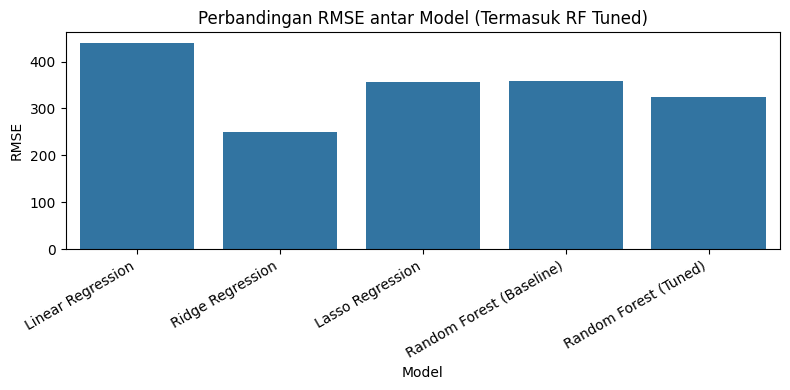

In [87]:
# Visualisasi ulang setelah ada RF Tuned
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="RMSE")
plt.xticks(rotation=30, ha="right")
plt.title("Perbandingan RMSE antar Model (Termasuk RF Tuned)")
plt.tight_layout()
plt.show()


In [88]:
# Block 9 – Cross Validation untuk Random Forest (Tuned)

best_model_name = "Random Forest (Tuned)"
best_model = fitted_models[best_model_name]

# 5-Fold Cross Validation di seluruh data
cv_scores = cross_val_score(
    best_model,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

rmse_scores = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE ({best_model_name}):")
print("RMSE per fold:", rmse_scores)
print("Mean RMSE     :", rmse_scores.mean())
print("Std RMSE      :", rmse_scores.std())


Cross-Validation RMSE (Random Forest (Tuned)):
RMSE per fold: [17.13703758 15.7953954  18.75546076 18.19965951 19.231519  ]
Mean RMSE     : 17.823814450154906
Std RMSE      : 1.231016067297288


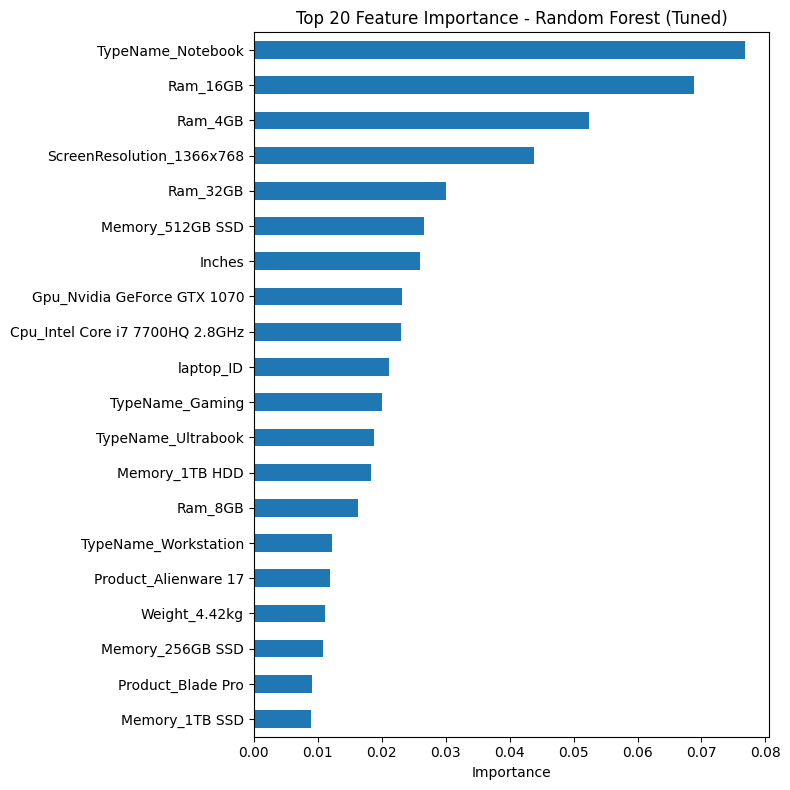

In [89]:
# Block 10 – Feature Importance untuk Random Forest (Tuned)

# Ambil model RandomForest dari pipeline
rf_best = best_model.named_steps["model"]

# Mendapatkan nama fitur setelah One-Hot Encoding
feature_names_cat = best_model.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(categorical_features)
feature_names_num = numerical_features
all_feature_names = np.concatenate([feature_names_cat, feature_names_num])

importances = rf_best.feature_importances_

feat_importances = pd.Series(importances, index=all_feature_names)
feat_importances_sorted = feat_importances.sort_values(ascending=True).tail(20)  # 20 fitur paling penting

plt.figure(figsize=(8, 8))
feat_importances_sorted.plot(kind="barh")
plt.title("Top 20 Feature Importance - Random Forest (Tuned)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


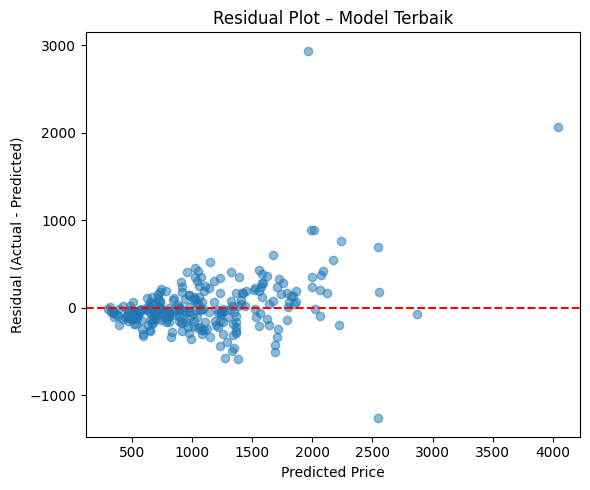

In [90]:
# Block 11 – Residual Analysis

# Prediksi dengan model terbaik
y_pred_best = best_model.predict(X_test)

residuals = y_test - y_pred_best

plt.figure(figsize=(6, 5))
plt.scatter(y_pred_best, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot – Model Terbaik")
plt.tight_layout()
plt.show()


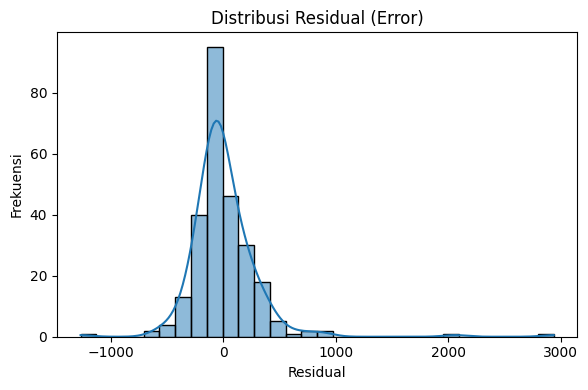

In [91]:
# Distribusi error
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribusi Residual (Error)")
plt.xlabel("Residual")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


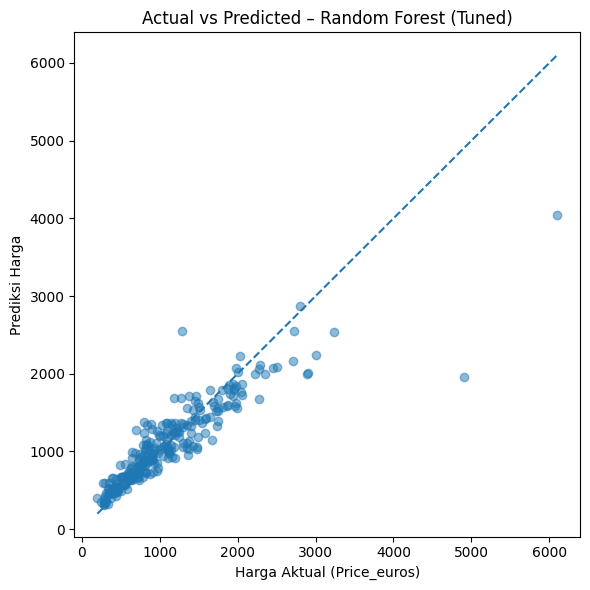

In [92]:
# Optional: Actual vs Predicted plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.xlabel("Harga Aktual (Price_euros)")
plt.ylabel("Prediksi Harga")
plt.title(f"Actual vs Predicted – {best_model_name}")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.tight_layout()
plt.show()


In [93]:
# Block 12 – Export Model Terbaik (Pipeline Lengkap)

joblib.dump(best_model, "best_laptop_price_pipeline.pkl")
print("Model pipeline terbaik berhasil disimpan sebagai 'best_laptop_price_pipeline.pkl'")


Model pipeline terbaik berhasil disimpan sebagai 'best_laptop_price_pipeline.pkl'
